# Using XGBoostClassifier to Predict Activities


## 1. Load and Explore a CSV file


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss



In [3]:
train_df = pd.read_csv('train_data_features_clean.csv', low_memory=False)
test_df = pd.read_csv('test_data_features_clean.csv', low_memory=False)
full_df = pd.read_csv('data_features_clean.csv', low_memory=False)

In [4]:
full_data = full_df.iloc[:, 6:]
train_data = train_df.iloc[:, 6:]
test_data = test_df.iloc[:,6:]

In [5]:
full_data.head()

,Activity,emg_std,emg_skew,emg_kurtosis,emg_raw_entropy,emg_raw_median_freq,emg_raw_mean_freq,emg_env_entropy,emg_env_median_freq,emg_env_mean_freq,...,accWz_pcount,accWz_abmean,accWz_npeaks,accWz_skew,accWz_kurtosis,accWz_energy,accWz_momentum,accWx_accWy_corr,accWx_accWz_corr,accWy_accWz_corr
0,run,0.402700,0.022782,1.626041,7.563331,11.2,15.791432,2.771572,0.1,0.480087,...,2846.0,2019.0,80.0,0.325623,0.284045,9.550141,0.184125,-0.701666,0.520737,-0.461837
1,run,0.490662,-0.156981,0.924532,7.393067,10.8,15.655208,4.025260,0.4,1.299583,...,1299.0,3174.0,80.0,-1.007241,0.186536,9.096791,0.122584,-0.732768,0.836656,-0.767018
2,run,0.617994,0.279592,0.700598,7.752997,12.2,17.131119,3.481311,0.4,0.986913,...,1335.0,3045.0,66.0,-0.743305,-0.502319,16.013050,0.208502,-0.701833,0.932318,-0.765428
3,run,0.568769,0.143795,1.043682,7.628066,11.0,16.753705,3.825489,0.4,1.161226,...,1691.0,3068.0,71.0,-0.821619,-0.255925,15.859154,0.228948,-0.660435,0.884632,-0.715693
4,run,0.638836,0.025813,0.500529,7.463735,12.8,17.379714,3.697093,0.2,0.876059,...,1819.0,3066.0,66.0,-0.800175,-0.277507,10.840314,0.162273,-0.657188,0.882543,-0.729674


In [6]:
print("full data shape is: ", full_data.shape, "training set shape is: ", train_data.shape, " testing set shape is: ", test_data.shape)

full data shape is:  (2586, 360) training set shape is:  (2068, 360)  testing set shape is:  (518, 360)


In [138]:
#activity_df.isnull().values.any()

In [7]:
full_data["Activity"].unique()

array(['run', 'walk_after', 'baseline', 'lift', 'greetings',
       'gesticulate', 'walk_before', 'jumps'], dtype=object)

In [141]:
all_motions = train_data["Activity"].unique()

In [8]:
unique_values, counts = np.unique(full_data['Activity'], return_counts=True)

count_motions = pd.DataFrame({ "counts": counts, "activities":unique_values})
count_motions
#print("values: ", unique_values)
#print("counts: ", counts)

,counts,activities
0,53,baseline
1,127,gesticulate
2,53,greetings
3,12,jumps
4,79,lift
5,1784,run
6,220,walk_after
7,258,walk_before


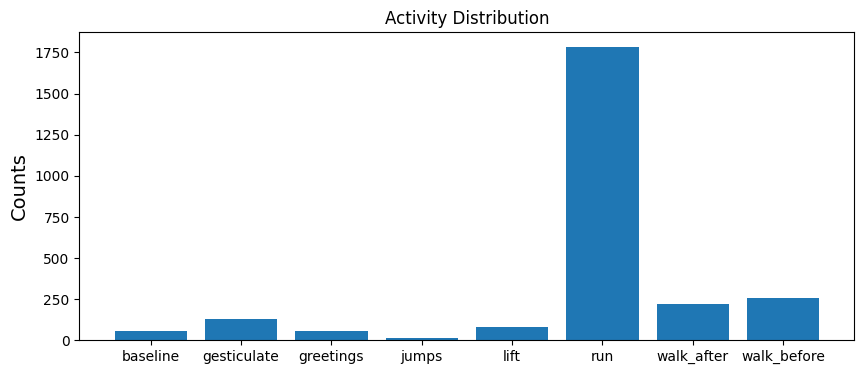

In [12]:
plt.figure(figsize = (10, 4))
plt.bar(count_motions['activities'], height = count_motions['counts'])
#plt.xlabel("Activities", fontsize = 14)
plt.ylabel('Counts', fontsize = 14)
plt.title("Activity Distribution")
plt.savefig("activity_distribution.png")
plt.show()

#### The 8 classes are highly imbalanced

In [13]:
unique_values, counts = np.unique(test_data['Activity'], return_counts=True)

count_motions = pd.DataFrame({ "counts": counts, "activities":unique_values})
count_motions
#print("values: ", unique_values)
#print("counts: ", counts)

,counts,activities
0,11,baseline
1,25,gesticulate
2,11,greetings
3,2,jumps
4,16,lift
5,357,run
6,44,walk_after
7,52,walk_before


In [14]:
activity_encoder = {'baseline':0,'lift':1,
                    'greetings':2, 
                    'gesticulate':3, 'jumps':4, 
                    'walk_before':5,
                    'run':6, 
                    'walk_after':7}

In [15]:
train_data['Activity'] = train_data['Activity'].replace(activity_encoder)
train_data['Activity'] = pd.to_numeric(train_data['Activity'])
  
test_data['Activity'] = test_data['Activity'].replace(activity_encoder)
test_data['Activity'] = pd.to_numeric(test_data['Activity'])

In [16]:
#test_data['Activity'].unique()

In [17]:
X_train=train_data.iloc[:,1:]
y_train=train_data.iloc[:,:1]
X_test = test_data.iloc[:,1:]
y_test = test_data.iloc[:, :1]

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [504]:
#X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, 
#                                                    test_size = 0.3, stratify = y_train, shuffle=True, random_state=11)

#print("X_train shape ", X_train2.shape)
#print("X_test shape ", X_val.shape)
#print("y_train shape ", y_train2.shape)
#print("y_test shape ", y_val.shape)

In [22]:
import xgboost as xgb
import time


In [20]:
#calculate the sample weights to address the imbalance of each class in contributing to the loss function.

from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train['Activity'].values 
)

In [23]:
max_depths = [ 2,3 ]
n_trees = [600,650]
lr = [ 0.4, 0.45]
colsample = [0.3, 0.4]
#sp = [0.5, 0.65, 0.8]

ti = time.time()


grid_cv = GridSearchCV(xgb.XGBClassifier(tree_method = 'hist'), 
                          param_grid = {'max_depth':max_depths, 
                                        'n_estimators':n_trees,
                                        'learning_rate' : lr,
                                         'colsample_bytree': colsample,},
                                         #  'subsample': sp}, # and n_estimators here
                          scoring = 'neg_log_loss', 
                          cv = 5,
                          n_jobs=-1) 

#grid_cv.fit(X_train2, y_train2, eval_set=[(X_train2, y_train2), (X_val, y_val)])
# passing the sample_weights to the .fit() function 
grid_cv.fit(X_train, y_train, sample_weight=sample_weights)

tf= time.time()
print("the total time of gridsearchcv is: ", tf-ti)

the total time of gridsearchcv is:  71.86749792098999


In [24]:
print("cv best params: ", grid_cv.best_params_)
print("the best score (log_loss): ",grid_cv.best_score_)

cv best params:  {'colsample_bytree': 0.4, 'learning_rate': 0.45, 'max_depth': 2, 'n_estimators': 650}
the best score (log_loss):  -0.10102487725109507


In [25]:
#get the best estimator

xgb_clf_best = grid_cv.best_estimator_

In [503]:
#results = xgb_clf_best.evals_result()

#plt.figure(figsize=(8,6))
#plt.plot(results["validation_0"]["mlogloss"], label="Training loss")
#plt.plot(results["validation_1"]["mlogloss"], label="Validation loss")
#plt.axvline(xgb_clf_best.best_iteration, color="gray", label="Optimal tree number")
#plt.xlabel("Number of trees")
#plt.ylabel("Loss")
#plt.legend(loc='upper left', fontsize=9)
#plt.show()

In [26]:
#make predictions on the test set.

y_pred = xgb_clf_best.predict(X_test)

In [27]:
activity_labels = ['baseline','lift',
                    'greetings', 
                    'gesticulate', 'jumps', 
                    'walk_before',
                    'run', 
                    'walk_after']

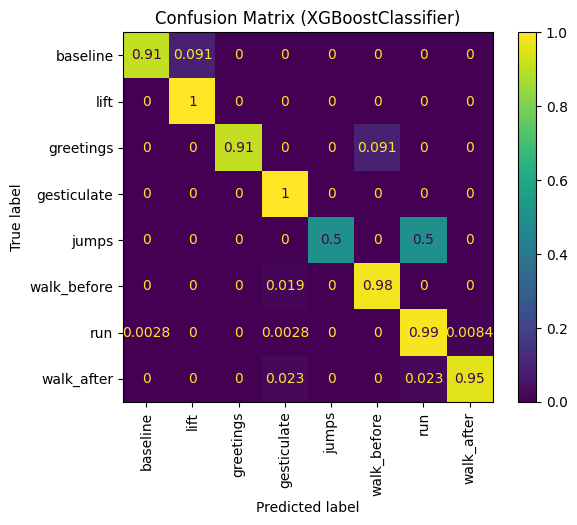

In [36]:
#plot the normalized confusion matrix 
cmp = ConfusionMatrixDisplay.from_predictions(y_test,y_pred,normalize='true', display_labels = activity_labels, xticks_rotation='vertical')
plt.title("Confusion Matrix (XGBoostClassifier)")
plt.savefig("CM_XGB")
plt.show()

In [29]:
#obtain the feature importance scores from XGBoostClassifier

importance_xgb= xgb_clf_best.get_booster().get_score(importance_type='gain')
importance_xgb

{'emg_std': 10.700129508972168,
 'emg_skew': 1.471778392791748,
 'emg_kurtosis': 10.303607940673828,
 'emg_raw_entropy': 0.11526159942150116,
 'emg_raw_median_freq': 0.44590282440185547,
 'emg_raw_mean_freq': 0.06587957590818405,
 'emg_env_entropy': 0.7627940773963928,
 'emg_env_mean_freq': 0.10271073132753372,
 'emg_power_band_1': 10.657992362976074,
 'emg_power_band_2': 3.1622657775878906,
 'emg_power_band_3': 0.021713897585868835,
 'emg_power_band_4': 4.799129962921143,
 'emg_power_band_5': 0.6374949812889099,
 'emg_onsets': 0.30894380807876587,
 'emg_onsets_reg': 4.8086090087890625,
 'ppg_wrist_a_S': 0.6465253829956055,
 'ppg_wrist_t_S': 0.0039387173019349575,
 'ppg_wrist_t_C': 0.429526150226593,
 'ppg_wrist_SW_10': 2.5454187393188477,
 'ppg_wrist_SW_25': 0.00488406652584672,
 'ppg_wrist_SW_66': 0.16244716942310333,
 'ppg_wrist_SW_75': 0.09642808884382248,
 'ppg_wrist_DW_10': 0.01233026385307312,
 'ppg_wrist_DW_25': 2.5343786546727642e-05,
 'ppg_wrist_DW_33': 1.5089476108551025,
 '

In [39]:
#get the top 20 features

keys = list(importance_xgb.keys())
values = list(importance_xgb.values())

importance_feature_df = pd.DataFrame(data=values, index=keys, columns=["importance_score"]).sort_values(by = "importance_score", ascending=False)
top20_features=importance_feature_df.nlargest(20, columns="importance_score")
top20_features

,importance_score
accWx_fft_skew,93.585037
accWx_energy,88.590790
ppg_finger_DW_SW_10,85.112656
accCHy_max,74.115967
accWz_npeaks,73.274269
accWy_fft_mean,68.146027
accWz_fft_skew,67.750275
accCHy_fft_mean,51.097248
accCHz_iqr,49.928036
accWy_mean,48.899971


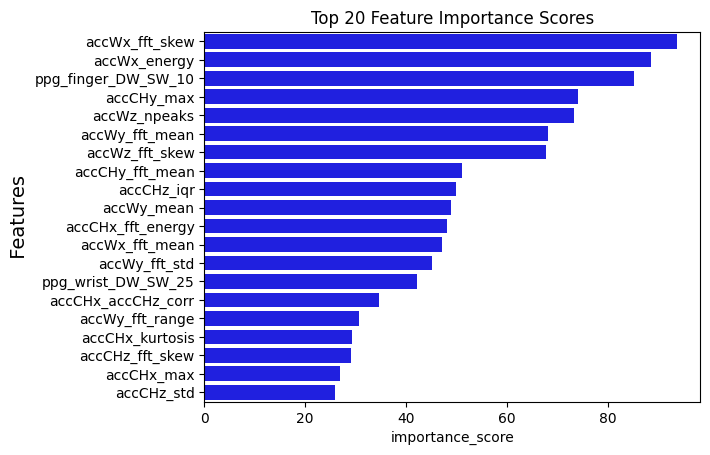

In [42]:
sns.barplot(x='importance_score', y=top20_features.index, data=top20_features,
            label="Total", color="b")
plt.title("Top 20 Feature Importance Scores")
plt.ylabel(" Features ", fontsize=14)
plt.savefig("Top20_features.png")
plt.show()

## Summary

The XGBoostClassifier overall does well in predicting the human activities using the features extracted from various biosignals. The most important features come from the "ACC" signal. It makes sense because the accelerometer directly measures the accelerations along x, y, z direction for motions of the wrist and the chest. 

One shortcoming of the XGBoostClassifier is that it misclassifis the "jump" activity as "run" activity. We only have 2 "jump" data point in the test set. We also only have 10 "jump" data point in the training set. It is not surprising that the XGBoost algorithm does not do well on the class with the smallest number of data point.

________

Notebook offered by Dr. Ming Li. All right reserved.
Contact: li.13449@osu.edu